# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta
from scipy.stats import pearsonr

%matplotlib inline
# plt.rcParams['font.size'] = 18

### lets get % of flow to each CS month to month for the full 5 years

In [2]:
def get_transport(mydata, section, starttime, endtime):
    time = endtime-starttime+1
    transports = (mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    sumTr = sum(transports)
    
    transports = (mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    totalTr = sum(transports)
    return sumTr, totalTr

In [3]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sec_nums = [2,3,4,5,6]
admiralty = np.array([])
deception = np.array([])
rosario = np.array([])
sanjuan = np.array([])
haro = np.array([])
sections = [admiralty, deception, rosario, sanjuan, haro]
all_total = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for j in range(len(sec_nums)):
            temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
            sections[j] = np.append(sections[j],temp)
        all_total = np.append(all_total, totalT)

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        totalT = sum((mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)

        for j in range(len(sec_nums)):
            temp = sum((mydata.final_transp[(mydata.final_section==sec_nums[j]) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)
            sections[j] = np.append(sections[j],temp)       
        all_total = np.append(all_total, totalT)
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    for j in range(len(sec_nums)):
        temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sections[j] = np.append(sections[j],temp)
    all_total = np.append(all_total, totalT)

In [4]:
admiralty = sections[0]
deception = sections[1]
rosario = sections[2]
sanjuan = sections[3]
haro = sections[4]

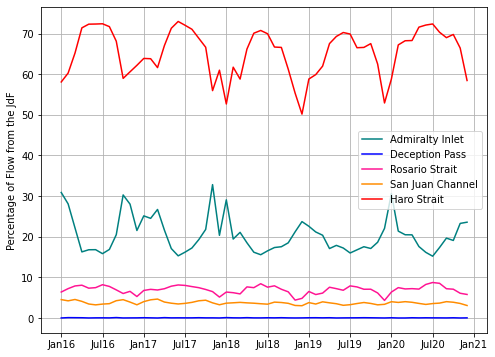

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(admiralty/all_total*100, c='teal',label="Admiralty Inlet")
ax.plot(deception/all_total*100, c='b',label="Deception Pass")
ax.plot(rosario/all_total*100, c='deeppink',label="Rosario Strait")
ax.plot(sanjuan/all_total*100, c='darkorange', label="San Juan Channel")
ax.plot(haro/all_total*100, c='r',label="Haro Strait")
ax.legend()
ax.set_ylabel("Percentage of Flow from the JdF")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
ax.grid()

In [6]:
print("haro average = "+str(sum(haro)/len(haro)))
print("rosario average = "+str(sum(rosario)/len(rosario)))
print("sanjuan average = "+str(sum(sanjuan)/len(sanjuan)))

print("admiralty average = "+str(sum(admiralty)/len(admiralty)))
print("deception average = "+str(sum(deception)/len(deception)))

print('SoG average = '+str((sum(haro)+sum(rosario)+sum(sanjuan))/len(haro)))
print('Puget average = '+str((sum(admiralty)+sum(deception))/len(haro)))

haro average = 47043.53629694011
rosario average = 5059.256530137992
sanjuan average = 2621.0124974082623
admiralty average = 13583.884002511168
deception average = 53.380141421131825
SoG average = 54723.80532448636
Puget average = 13637.2641439323


In [7]:
# (sum(haro[12:24])+sum(rosario[12:24])+sum(deception[12:24]))/12
print('SoG 2017 average = '+str((sum(haro[12:24])+sum(rosario[12:24])+sum(sanjuan[12:24]))/12))
print('Puget 2017 average = '+str((sum(admiralty[12:24])+sum(deception[12:24]))/12))

SoG 2017 average = 55788.09422595443
Puget 2017 average = 14265.766659171655


In [8]:
# overall summer average
#april:sep, may:oct, mar:sep, apr:nov, mar:oct
#3:9, 4+12:10+12, 2+12*2:9+12*2, 3*12*3:11+12*3, 2+12*4:10*12*4 
num_mo = 30
HR = np.array(haro)+np.array(rosario)+np.array(sanjuan)
print(np.sum([np.sum(HR[3:9]),np.sum(HR[4+12:10+12]),np.sum(HR[2+12*2:9+12*2]),np.sum(HR[3*12*3:11+12*3]),np.sum(HR[2+12*4:10*12*4])])/num_mo)

PS = np.array(admiralty)+np.array(sanjuan)
print(np.sum([np.sum(PS[3:9]),np.sum(PS[4+12:10+12]),np.sum(PS[2+12*2:9+12*2]),np.sum(PS[3*12*3:11+12*3]),np.sum(PS[2+12*4:10*12*4])])/num_mo)

64709.0912898056
17183.659252539073


In [9]:
months=np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i)) for i in range(60)])

In [10]:
season = [pd.to_datetime('2016-04-01'), pd.to_datetime('2016-09-01'),
 pd.to_datetime('2017-05-01'),pd.to_datetime('2017-10-01'),
 pd.to_datetime('2018-03-01'),pd.to_datetime('2018-09-01'),
 pd.to_datetime('2019-04-01'),pd.to_datetime('2019-11-01'),
 pd.to_datetime('2020-03-01'),pd.to_datetime('2020-10-01')]

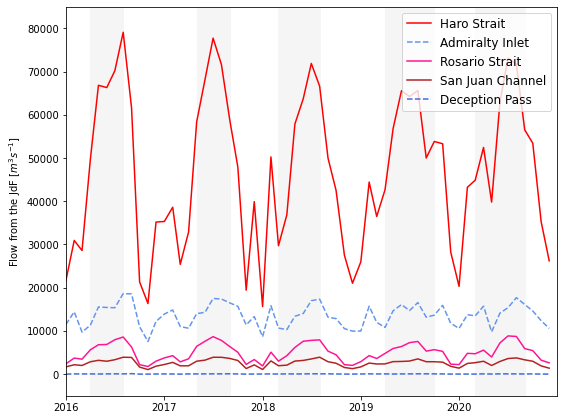

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

plt.rcParams['font.size'] = 12

ax.plot(months,haro, c='r', label="Haro Strait")
ax.plot(months,admiralty, c='cornflowerblue',label="Admiralty Inlet",linestyle='dashed')
ax.plot(months,rosario, c='deeppink',label="Rosario Strait")
ax.plot(months,sanjuan, c='firebrick', label="San Juan Channel")
ax.plot(months,deception, c='royalblue',label="Deception Pass",linestyle='dashed')

ax.legend(loc="upper right",fontsize=12)
ax.set_ylabel("Flow from the JdF [$m^{3}s^{-1}$]")
ax.set_xticks(np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i*12)) for i in range(6)]))
ax.set_xticklabels(['2016','2017','2018','2019','2020','2021'])#,fontsize=14)
ax.set_ylim(-5000,85000)
ax.set_xlim(pd.to_datetime('2016-01-01'),pd.to_datetime('2020-12-31'))

# season = np.array([pd.to_datetime(pd.to_datetime('2016-04-01') + relativedelta(months=6*i)) for i in range(10)])
for i in range(0, len(season),2):
    ax.fill_between(months, -5000, 85000, where=(months<season[i+1])&(months>=season[i]), color='whitesmoke')
plt.tight_layout()
# plt.savefig("./figures/channelFlow.pdf")

In [12]:
print(np.max(rosario))
print(np.max(sanjuan))
print(np.max(deception))

8853.32941008445
3932.237718326156
126.11675874224515


In [13]:
# residence time of SoG and Puget based on volume of these basins?
V_pug = 168*(1000**3) # km3 converted to m3, easily found online
V_sog = 222000*28000*155 #couldn't find quickly nad decided not to bother, based on average width, length, and depth from Thomson 1981

(-1.0, 61.0)

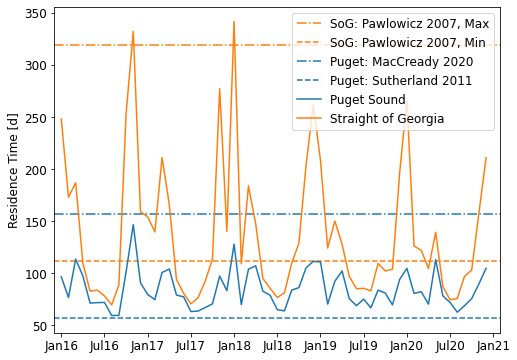

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot([-1,61],[319,319], c='tab:orange',  linestyle='-.',label="SoG: Pawlowicz 2007, Max")
ax.plot([-1,61],[112,112], c='tab:orange', linestyle='--',label="SoG: Pawlowicz 2007, Min")
ax.plot([-1,61],[157,157], c='tab:blue', linestyle='-.',label="Puget: MacCready 2020")
ax.plot([-1,61],[57,57], c='tab:blue', linestyle='--',label="Puget: Sutherland 2011")
ax.plot((V_pug/(admiralty+deception))/(60*60*42), c='tab:blue',label="Puget Sound")
ax.plot((V_sog/(haro+sanjuan+rosario))/(60*60*42), c='tab:orange',label="Straight of Georgia")
ax.legend()
ax.set_ylabel("Residence Time [d]")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
# ax.grid()
ax.set_xlim([-1,61])

not wild compared to previous estiamtions of the residence time of the SoG (112-319 in Pawlowicz 2007) or Puget (57 in Sutherland 2011 and 157 in MacCready 2020)

## Now what if we split up the flow based upon water mass definitions

In [15]:
# section numbers
Meander = 0
Admiralty = 2
Deception = 3
Rosario = 4
Sanjuan = 5
Haro = 6

In [16]:
starttime = 1
endtime = 720
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
d = 150

freshSOG = np.array([])
freshPS = np.array([])
    
cucSOG = np.array([])
cucPS = np.array([])
    
upSOG = np.array([])
upPS = np.array([])
SoG = np.array([])
PS = np.array([])


#216 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                          & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                         & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)),(mydata.final_section==Sanjuan))
                                               & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                              & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                             & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                           & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
          
        freshSOG = np.append(freshSOG, XfreshSOG)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
            

#2019 and 2018 (both done month by month)
year = [18,19]
str_mo = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        start, end = 1, 720
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                               & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                              & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                             & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                           & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
        
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
    XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                      & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                     & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
    XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                           & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                          & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                         & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                        & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==Haro),(mydata.final_section==Rosario)), (mydata.final_section==Sanjuan))
                                        & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Admiralty),(mydata.final_section==Deception))
                                       & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
    freshSOG = np.append(freshSOG, XfreshSOG)
    freshPS = np.append(freshPS, XfreshPS)

    cucSOG = np.append(cucSOG, XcucSOG)
    cucPS = np.append(cucPS, XcucPS)

    upSOG = np.append(upSOG, XupSOG)
    upPS = np.append(upPS, XupPS)
    
    SoG = np.append(SoG, XSOG)
    PS = np.append(PS, XPS)

In [17]:
# lets calculate the peason's correlation coefficient 
sg_up, _ = pearsonr(SoG, upSOG)
sg_cuc, _ = pearsonr(SoG, cucSOG)
sg_fresh, _ = pearsonr(SoG, freshSOG)

ps_up, _ = pearsonr(PS, upPS)
ps_cuc, _ = pearsonr(PS, cucPS)
ps_fresh, _ = pearsonr(PS, freshPS)

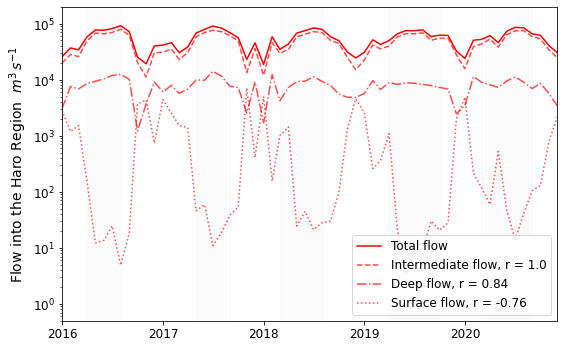

In [18]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(months, SoG, c='r', label='Total flow')
ax.plot(months, upSOG, c='r', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(sg_up,2)), ls='dashed')
ax.plot(months, cucSOG, c='r', alpha = 0.7, label='Deep flow, r = '+str(np.round(sg_cuc,2)), ls='dashdot')
ax.plot(months, freshSOG, c='r', alpha = 0.7, label='Surface flow, r = '+str(np.round(sg_fresh,2)), ls='dotted')
ax.set_yscale('log')
ax.set_ylabel('Flow into the Haro Region  $m^3\,s^{-1}$', fontsize=14)
ax.set_xticks([months[i] for i in [0,12,24,36,48]])
ax.set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax.legend(loc='lower right',fontsize=12)
ax.set_ylim([0.5,200000])
ax.set_xlim([months[0],months[-1]])

for i in range(0, len(season),2):
    ax.fill_between(months, 0.5,200000, where=(months<season[i+1])&(months>=season[i]), color='whitesmoke', alpha=0.4)
#     ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()

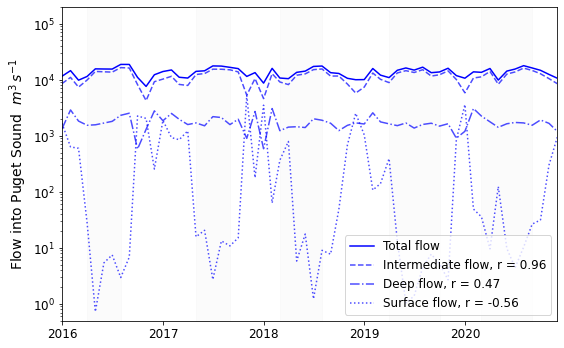

In [19]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(months, PS, c='b', label='Total flow')
ax.plot(months, upPS, c='b', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(ps_up,2)), ls='dashed')
ax.plot(months, cucPS, c='b', alpha = 0.7, label='Deep flow, r = '+str(np.round(ps_cuc,2)), ls='dashdot')
ax.plot(months, freshPS, c='b', alpha = 0.7, label='Surface flow, r = '+str(np.round(ps_fresh,2)), ls='dotted')
ax.set_yscale('log')
ax.set_ylabel('Flow into Puget Sound  $m^3\,s^{-1}$', fontsize=14)
ax.set_xticks([months[i] for i in [0,12,24,36,48]])
ax.set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax.legend(loc='lower right',fontsize=12)
ax.set_ylim([0.5,200000])
ax.set_xlim([months[0],months[-1]])

for i in range(0, len(season),2):
    ax.fill_between(months, 0.5,200000, where=(months<season[i+1])&(months>=season[i]), color='whitesmoke', alpha=0.4)
#     ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()

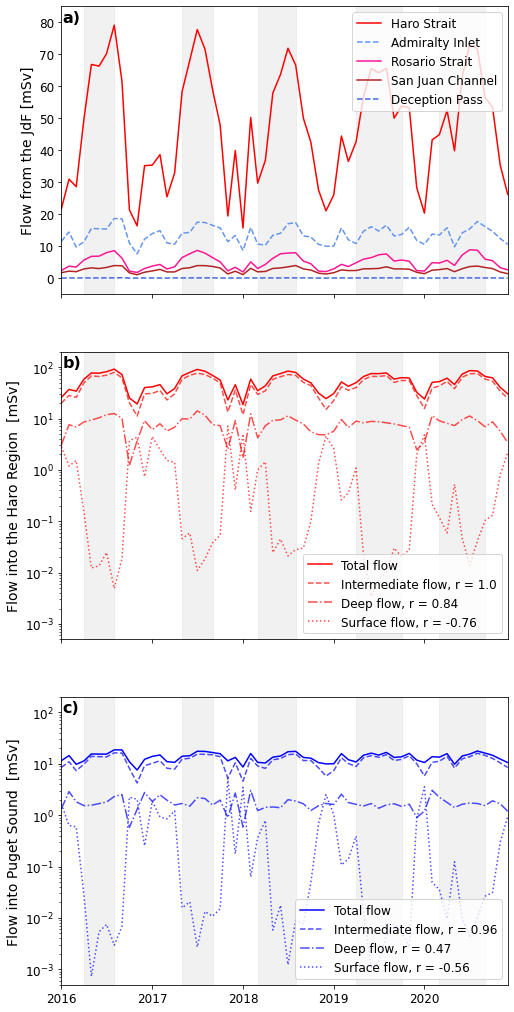

In [27]:
# alllllllll together

fig, ax = plt.subplots(3,1, figsize=(8,18))
plt.rcParams['font.size'] = 12

ax[0].plot(months,haro/1000, c='r', label="Haro Strait")
ax[0].plot(months,admiralty/1000, c='cornflowerblue',label="Admiralty Inlet",linestyle='dashed')
ax[0].plot(months,rosario/1000, c='deeppink',label="Rosario Strait")
ax[0].plot(months,sanjuan/1000, c='firebrick', label="San Juan Channel")
ax[0].plot(months,deception/1000, c='royalblue',label="Deception Pass",linestyle='dashed')
ax[0].legend(loc="upper right",fontsize=12)
ax[0].set_ylabel("Flow from the JdF [mSv]", fontsize=14)
ax[0].set_xticks(np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i*12)) for i in range(6)]))
ax[0].set_xticklabels([])#,fontsize=14)
ax[0].set_ylim(-5,85)
ax[0].set_xlim([months[0],months[-1]])

ax[1].plot(months, SoG/1000, c='r', label='Total flow')
ax[1].plot(months, upSOG/1000, c='r', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(sg_up,2)), ls='dashed')
ax[1].plot(months, cucSOG/1000, c='r', alpha = 0.7, label='Deep flow, r = '+str(np.round(sg_cuc,2)), ls='dashdot')
ax[1].plot(months, freshSOG/1000, c='r', alpha = 0.7, label='Surface flow, r = '+str(np.round(sg_fresh,2)), ls='dotted')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flow into the Haro Region  [mSv]', fontsize=14)
ax[1].set_xticks([months[i] for i in [0,12,24,36,48]])
ax[1].set_xticklabels([],fontsize=12)
ax[1].legend(loc='lower right',fontsize=12)
ax[1].set_ylim([0.0005,200])
ax[1].set_xlim([months[0],months[-1]])

ax[2].plot(months, PS/1000, c='b', label='Total flow')
ax[2].plot(months, upPS/1000, c='b', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(ps_up,2)), ls='dashed')
ax[2].plot(months, cucPS/1000, c='b', alpha = 0.7, label='Deep flow, r = '+str(np.round(ps_cuc,2)), ls='dashdot')
ax[2].plot(months, freshPS/1000, c='b', alpha = 0.7, label='Surface flow, r = '+str(np.round(ps_fresh,2)), ls='dotted')
ax[2].set_yscale('log')
ax[2].set_ylabel('Flow into Puget Sound  [mSv]', fontsize=14)
ax[2].set_xticks([months[i] for i in [0,12,24,36,48]])
ax[2].set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax[2].legend(loc='lower right',fontsize=12)
ax[2].set_ylim([0.0005,200])
ax[2].set_xlim([months[0],months[-1]])

for i in range(0, len(season),2):
    ax[0].fill_between(months, -5, 85, where=(months<season[i+1])&(months>=season[i]), color='lightgrey',alpha=0.3)
    ax[1].fill_between(months, 0.0005,200, where=(months<season[i+1])&(months>=season[i]), color='lightgrey', alpha=0.3)
    ax[2].fill_between(months, 0.0005,200, where=(months<season[i+1])&(months>=season[i]), color='lightgrey', alpha=0.3)

#labels
ax[0].text(pd.to_datetime('2016-1-5'), 80, 'a)', weight= "bold", fontsize=16)
ax[1].text(pd.to_datetime('2016-1-5'), 100, 'b)', weight= "bold", fontsize=16)
ax[2].text(pd.to_datetime('2016-1-5'), 100, 'c)', weight= "bold", fontsize=16)

plt.savefig("./figures/FlowHaroPuget.pdf")
